# Predicting Age From X-Rays

# Goal
Develop an algorithm to determine the age of a child by utilizing x-rays of hands (pediatric hand radiographs).

In [1]:
# Common variables for all models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau    

epochs = 200

batchSize = 25
imageLength = 200
imageHeight = 200

# Stop training when a monitored quantity has stopped improving after 20 epochs
earlyStop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduceLR = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

from keras import backend as K
print('\nData format for Keras is:', K.image_data_format())

Using TensorFlow backend.



Data format for Keras is: channels_last


## Expore the dataset

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# CSV file contains the id, age, and gender related to each x-ray
dataset = pd.read_csv("Input/boneage-dataset.csv")

# Dropping all rows with any NA values
dataset.dropna()

print('There are %d total data samples.' % dataset.shape[0])
print('\nData type for each column is:\n',dataset.dtypes)

dataset.head()

There are 12611 total data samples.

Data type for each column is:
 id         int64
boneage    int64
male        bool
dtype: object


id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

### Plot the distributions for id, boneage and male

Minimum and maximum of id is 1377 and 15610, respectively.
Minimum, maximum, mean, and standard deviation of bone age is 1, 228, 127.32, and 41.18 months, respectively.
Total number of male and female is 6833 (54.18%) and 5778 (45.82%), respectively.


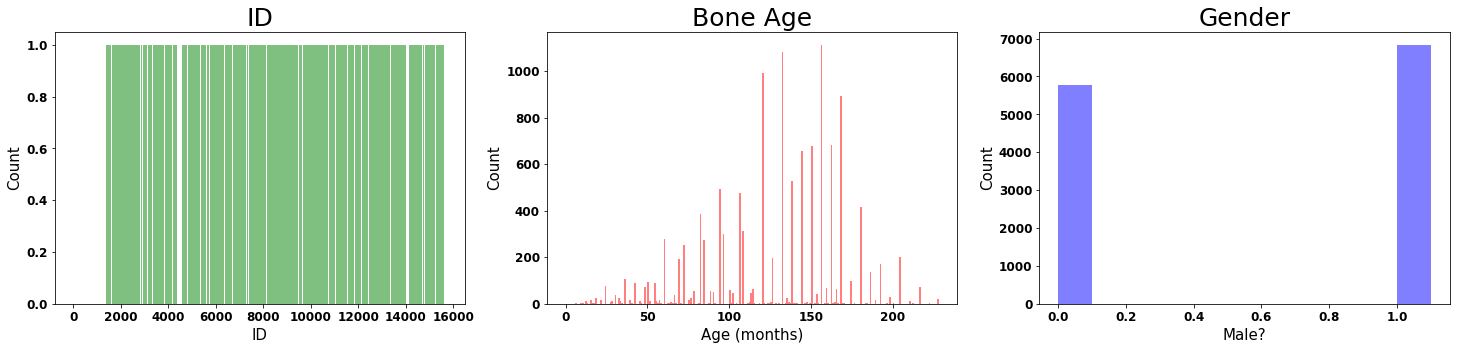

In [3]:
import PlottingTools as pt

myFigure = plt.figure(figsize=(25, 5)) 
myAxis1 = myFigure.add_subplot(1,3,1)
myAxis2 = myFigure.add_subplot(1,3,2)
myAxis3 = myFigure.add_subplot(1,3,3)

myAxis1.hist(dataset['id'], 15700, range = (0, 15700.0), color='g', alpha=0.5)
myAxis2.hist(dataset['boneage'], 228, range = (0, 228.0), color='r', alpha=0.5)
myAxis3.hist(dataset['male'], 11, range = (0, 1.1), color='b', alpha=0.5)

#Title and stuff
pt.setTitle(myAxis1, 'ID', 'ID', 'Count')
pt.setTitle(myAxis2, 'Bone Age', 'Age (months)', 'Count')
pt.setTitle(myAxis3, 'Gender', 'Male?', 'Count')

#Ticks
pt.setTicks(myAxis1)
pt.setTicks(myAxis2)
pt.setTicks(myAxis3)

myFigure.savefig('Plots/RawDistribution.pdf', bbox_inches='tight')

print('Minimum and maximum of id is %d and %d, respectively.' 
      %(dataset['id'].min(), dataset['id'].max()))
print('Minimum, maximum, mean, and standard deviation of bone age is %d, %d, %.2f, and %.2f months, respectively.' 
      %(dataset['boneage'].min(), dataset['boneage'].max(), dataset['boneage'].mean(), dataset['boneage'].std()))
print('Total number of male and female is %d (%.2f%%) and %d (%.2f%%), respectively.' 
      %(dataset[dataset['male']==1].shape[0], 
        dataset[dataset['male']==1].shape[0]*100/dataset.shape[0],
        dataset[dataset['male']==0].shape[0], 
        dataset[dataset['male']==0].shape[0]*100/dataset.shape[0]))

### Connect the x-ray images to the labels

In [4]:
import os

dataset['image_path'] = dataset['id'].map(lambda x: os.path.join('Input/boneage-dataset', '{}.png'.format(x)))

if dataset['image_path'].map(os.path.exists).sum() != dataset.shape[0]:
    print('Warning!! Only', dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total! \nWill continue with reduced dataset!!')
    dataset = dataset[dataset['image_path'].map(os.path.exists)]
else:
    print('Awesome!! All',dataset['image_path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total!')

Awesome!! All 12611 x-ray images found out of 12611 total!


### Split data in a stratified fashion

In [5]:
# Make new colum 'boneage_category' such that each category has the same number of samples

length = 15
categories_list = [x/length for x in range(length+1)]
print(categories_list, '\n')
categories = dataset['boneage'].quantile(q=categories_list)

categories_labels =[]
for i in range(categories.size):
    if i==categories.size-1: continue
    categories_labels.append(str(categories[categories.index[i]].astype('int'))+'-'+
                             str(categories[categories.index[i+1]].astype('int')))   
print(categories_labels, '\n')
    
dataset['boneage_category'] = pd.qcut(dataset['boneage'], q=categories_list, labels=categories_labels)
dataset.head()

[0.0, 0.06666666666666667, 0.13333333333333333, 0.2, 0.26666666666666666, 0.3333333333333333, 0.4, 0.4666666666666667, 0.5333333333333333, 0.6, 0.6666666666666666, 0.7333333333333333, 0.8, 0.8666666666666667, 0.9333333333333333, 1.0] 

['1-60', '60-78', '78-94', '94-104', '104-113', '113-120', '120-132', '132-138', '138-144', '144-150', '150-156', '156-162', '162-168', '168-180', '180-228'] 



id  boneage   male                      image_path boneage_category
0  1377      180  False  Input/boneage-dataset/1377.png          168-180
1  1378       12  False  Input/boneage-dataset/1378.png             1-60
2  1379       94  False  Input/boneage-dataset/1379.png            78-94
3  1380      120   True  Input/boneage-dataset/1380.png          113-120
4  1381       82  False  Input/boneage-dataset/1381.png            78-94

### Split data into training, validation, test sets (80/10/10)

In [6]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_validation = train_test_split(dataset, test_size=0.2, random_state=99, 
                                               stratify=dataset['boneage_category'])
dataset_validation, dataset_test = train_test_split(dataset_validation, test_size=0.5, random_state=99,
                                             stratify=dataset_validation['boneage_category'])
                                                                    
print("The training set has %d samples." % len(dataset_train))
print("The validation set has %d samples." % len(dataset_validation))
print("The test set has %d samples." % len(dataset_test))

The training set has 10088 samples.
The validation set has 1261 samples.
The test set has 1262 samples.


### Tools to preprocess the images for Keras

In [7]:
# Take a string-valued image path and returns 4D tensor

from keras.preprocessing import image                  
from tqdm import tqdm

def imageToTensor(imageToConvert):
    # Load the image as grayscale; w x h=imageLength x imageHeight
    img = image.load_img(imageToConvert, target_size=(imageLength, imageHeight))
    
    # Convert a PIL Image instance to a Numpy array with shape (imageLength, imageHeight, 3)
    x = image.img_to_array(img)
    
    # Convert 3D tensor to 4D tensor with shape (1, imageLength, imageHeight, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def imagesToTensor(imagesToConvert):
    listOfTensors = [imageToTensor(imageToConvert) for imageToConvert in tqdm(imagesToConvert)]
    return np.vstack(listOfTensors)

In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

# Convert every x-ray images to 4D tensors
X_train = imagesToTensor(dataset_train['image_path'])
X_validation = imagesToTensor(dataset_validation['image_path'])
X_test = imagesToTensor(dataset_test['image_path'])

100%|██████████| 1262/1262 [00:35<00:00, 35.42it/s]


In [9]:
# Rescale the images by dividing every pixel in every image by 255

# Rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_validation = X_validation.astype('float32')/255
X_test = X_test.astype('float32')/255

### One-hot encode the labels

In [10]:
from keras.utils import np_utils

# Bone age in the sample is from 0 to 228 months
y_train = dataset_train['boneage']
y_train = np_utils.to_categorical(y_train, 229)

y_validation = dataset_validation['boneage']
y_validation = np_utils.to_categorical(y_validation, 229)

y_test = dataset_test['boneage']
y_test = np_utils.to_categorical(y_test, 229)

print('One-hot labels:')
print(y_train[:5])

One-hot labels:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Create and configure augmented image generator

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation
datagen_train = ImageDataGenerator(
    width_shift_range=0.15,     # Fraction of total width for random horizontal shifts
    height_shift_range=0.15,    # Fraction of total height for random vertical shifts
    rotation_range = 15,        # Degree range for random rotations
    horizontal_flip=True)       # Randomly flip images horizontally
generator_train = datagen_train.flow(X_train, y_train, batch_size=batchSize)

datagen_validation = ImageDataGenerator()
generator_validation = datagen_validation.flow(X_validation, y_validation, batch_size=batchSize)

### Visualize a single training image in detail

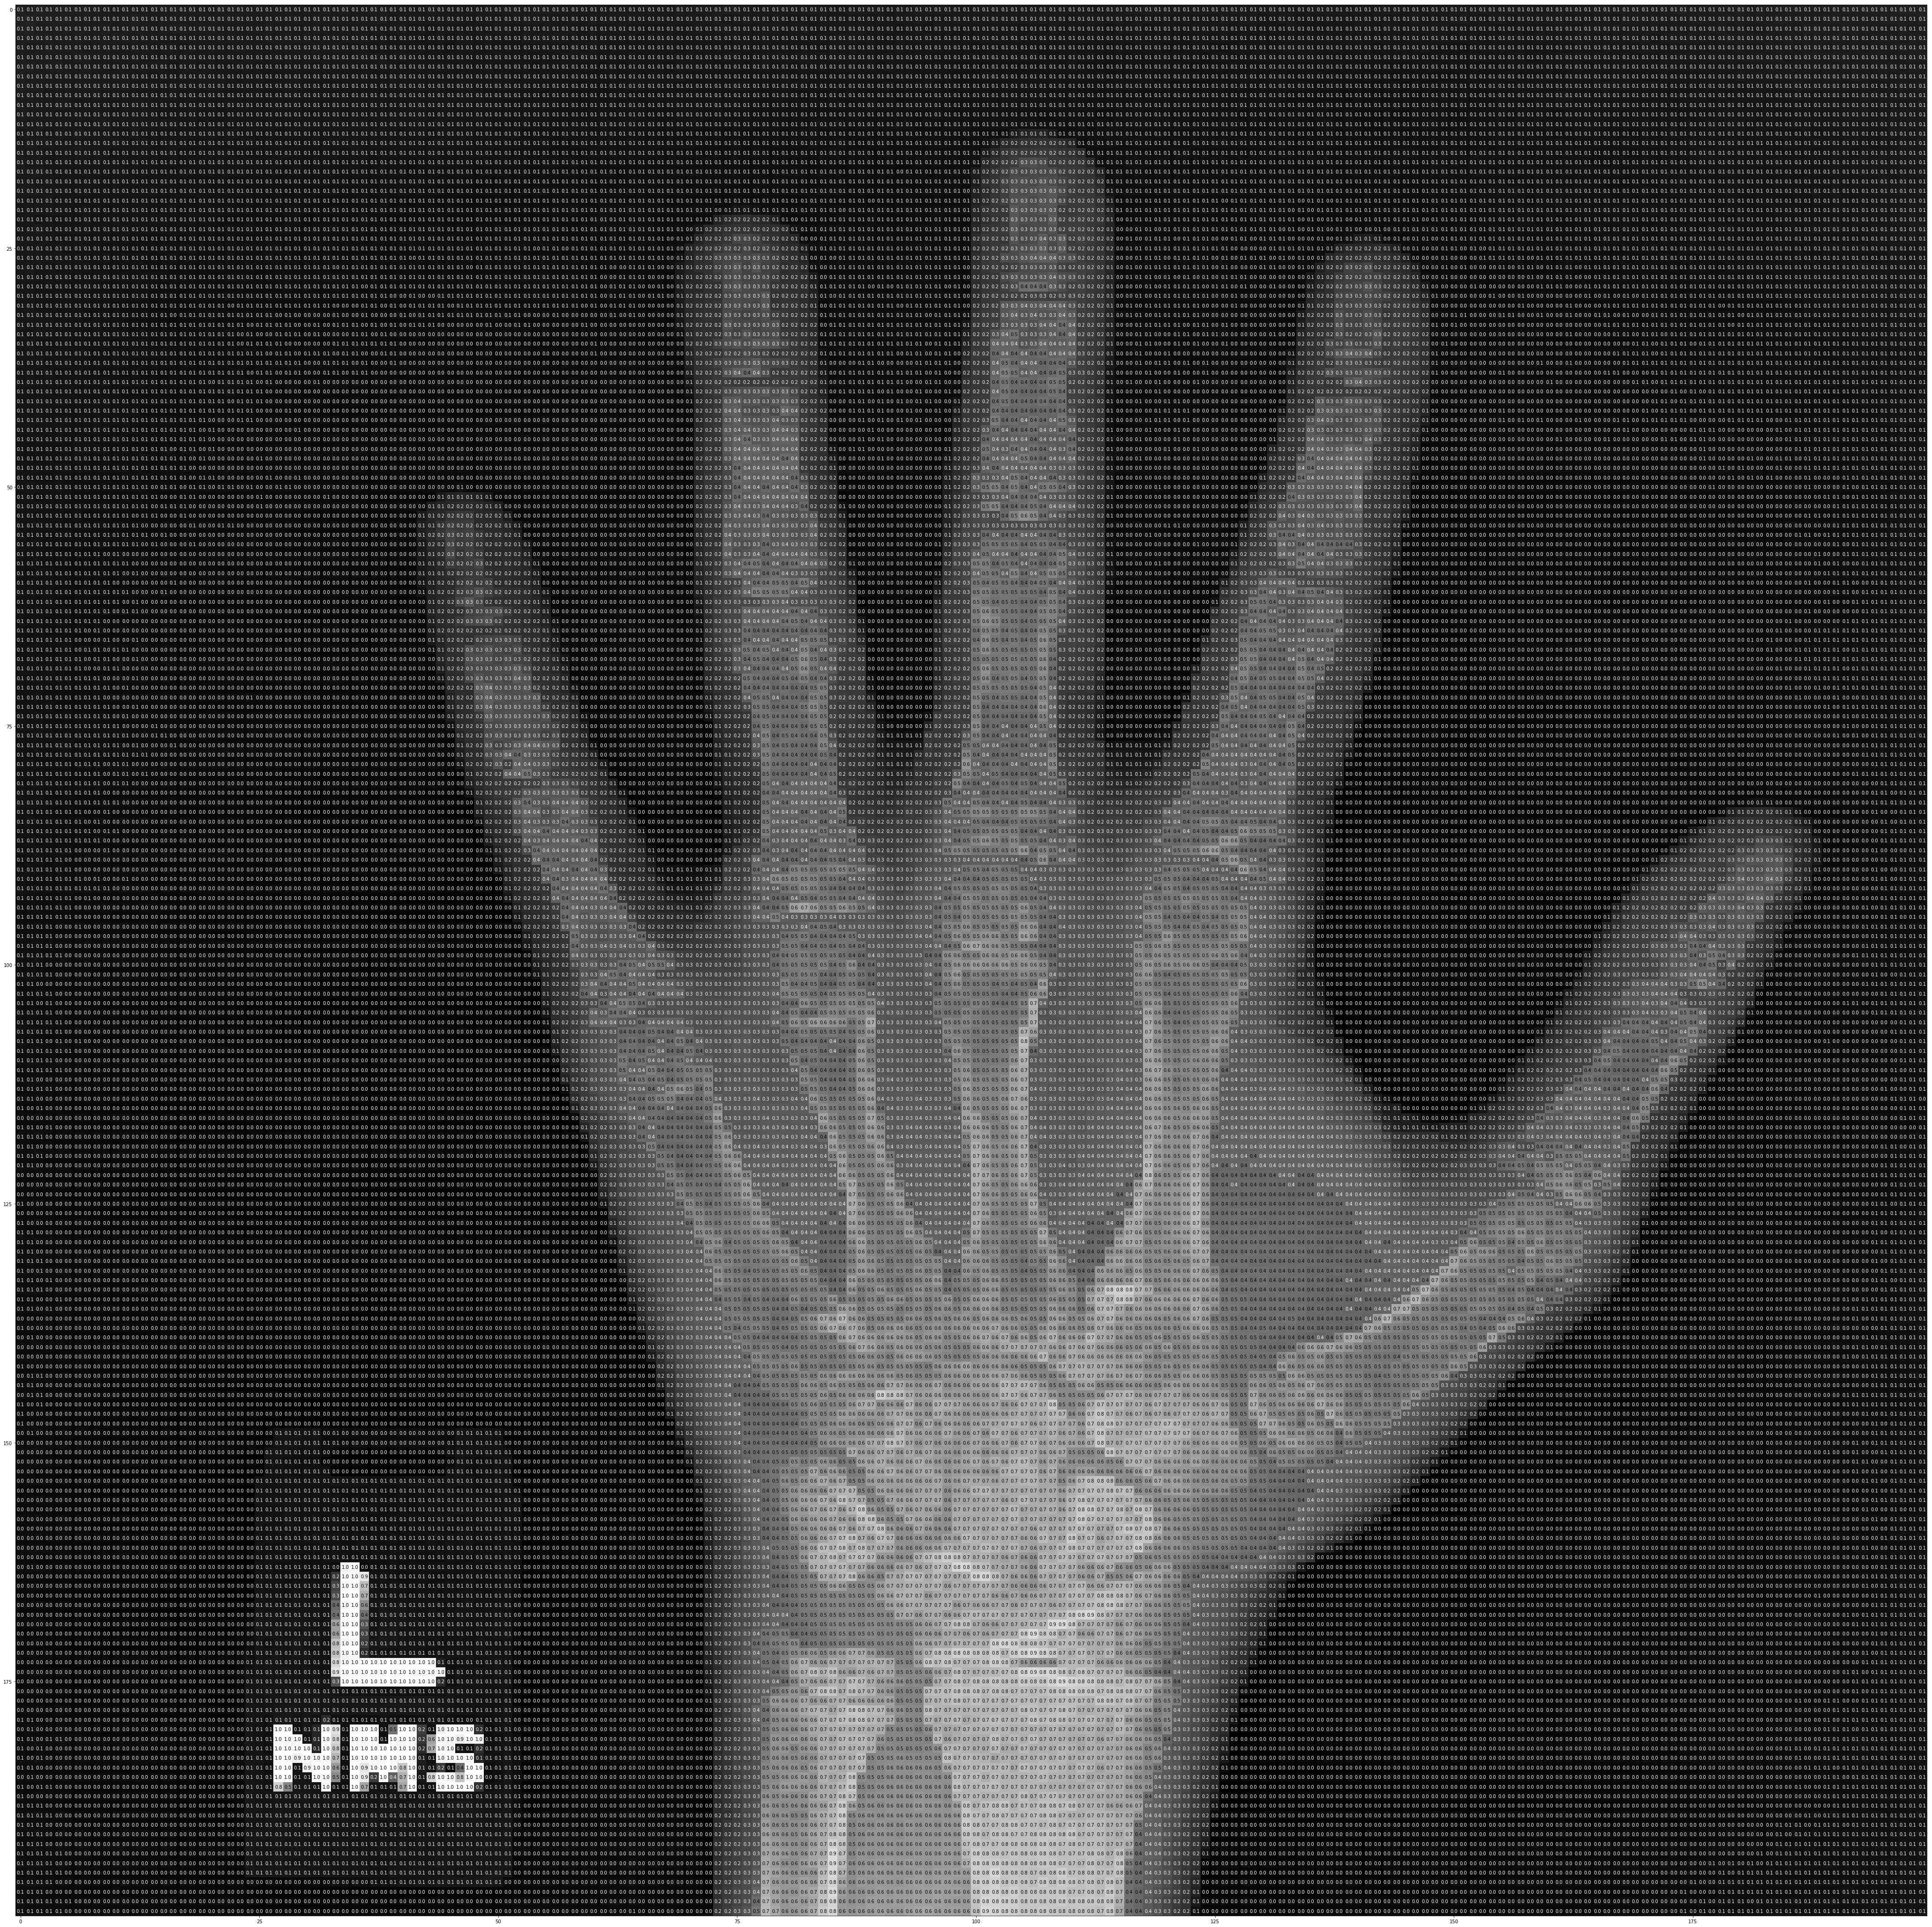

In [12]:
def visualizeImage(img, ax):
    ax.imshow(np.squeeze(img), cmap='gray')
    width, height, depth = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y][0],1)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y][0]<thresh else 'black')
            
fig = plt.figure(figsize = (75,75)) 
ax = fig.add_subplot(111)
visualizeImage(X_train[1], ax)

fig.savefig('Plots/SingleTrainingImage.pdf', bbox_inches='tight')

### Visualize original, processed, and augmented training images

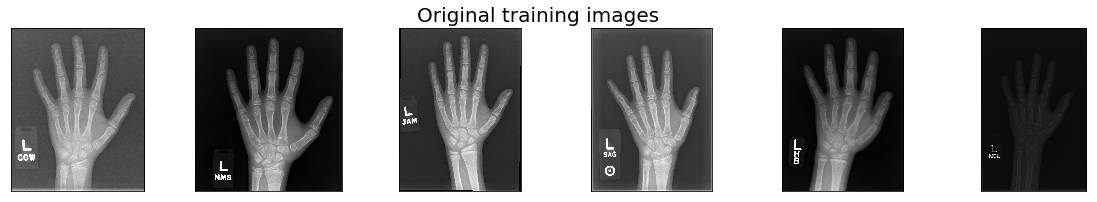

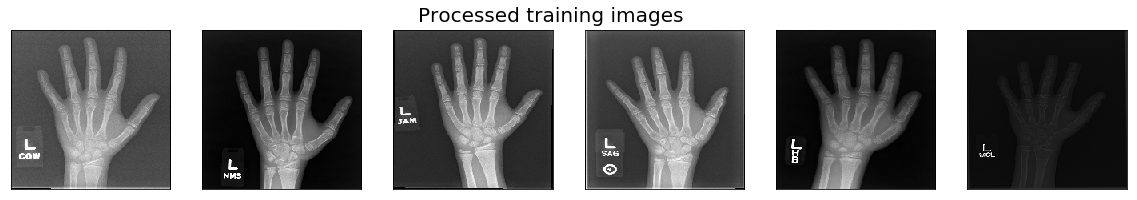

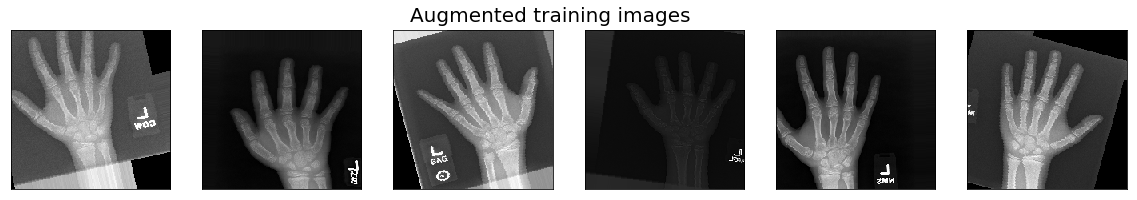

In [13]:
# Visualize the first six original, processed, and augmented training images
X_train_subset = X_train[:6]

fig = plt.figure(figsize=(20,3))
count = 0
for train_image in dataset_train['image_path'][:6]:
    ax = fig.add_subplot(1, 6, count+1, xticks=[], yticks=[])
    img = image.load_img(train_image)#, target_size=(imageLength, imageHeight))
    ax.imshow(img)
    count+=1
fig.suptitle('Original training images', fontsize=20)
plt.show()
fig.savefig('Plots/OriginalTrainingImages.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(20,3))
for i in range(0, len(X_train_subset)):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train_subset[i]))
fig.suptitle('Processed training images', fontsize=20)
plt.show()
fig.savefig('Plots/ProcessedTrainingImages.pdf', bbox_inches='tight')

fig = plt.figure(figsize=(20,3))
for X_batch in datagen_train.flow(X_train_subset, batch_size=6):
    for i in range(6):
        ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_batch[i]), cmap='gray')
    # Need to break the loop because the generator loops indefinitely
    break 
fig.suptitle('Augmented training images', fontsize=20)
plt.show()
fig.savefig('Plots/AugmentedTrainingImages.pdf', bbox_inches='tight')

# Benchmark model from scratch

### Define the benchmark model architecture

In [14]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import plot_model

benchmarkModel = Sequential()

benchmarkModel.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',input_shape=X_train[0].shape))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Flatten())         
benchmarkModel.add(Dense(500, activation='relu'))
benchmarkModel.add(BatchNormalization())
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Dense(229, activation='softmax'))

benchmarkModel.summary()
plot_model(benchmarkModel, to_file='Plots/BenchmarkModel.pdf')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
__________

### Compile the code

In [15]:
benchmarkModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the benchmark model (before training)

In [16]:
# Evaluate the test accuracy
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (before training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (before training): 0.0000%


### Train the benchmark model

Epoch 00000: val_loss improved from inf to 10.24371, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00001: val_loss improved from 10.24371 to 6.95377, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00002: val_loss improved from 6.95377 to 5.50558, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 5.50558 to 5.29035, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 5.29035 to 4.96792, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 4.96792 to 4.21050, saving model to SavedModels/BenchmarkBest.hdf5
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 4.21050 to 3.93230, saving model to SavedMod

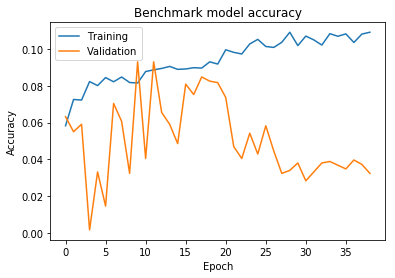

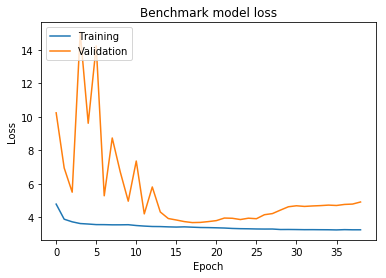

In [17]:
from keras.callbacks import ModelCheckpoint    

# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/BenchmarkBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = benchmarkModel.fit_generator(generator_train,
                                       steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                       validation_data=generator_validation, validation_steps=X_validation.shape[0] // batchSize,
                                       callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Benchmark model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Benchmark model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/BenchmarkLoss.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the benchmark model (after training)

In [18]:
# Load the model with the best classification accuracy on the validation set
benchmarkModel.load_weights('SavedModels/BenchmarkBest.hdf5')

# Calculate the classification accuracy on the test set
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (after training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (after training): 9.0333%


### Visualize the result of the benchmark model 

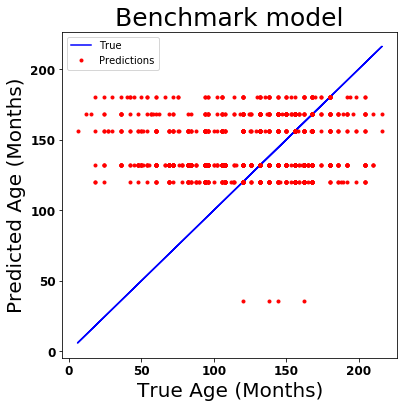

In [19]:
y_pred = benchmarkModel.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('Benchmark model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/BenchmarkResult.pdf', bbox_inches='tight')

# Model based on InceptionV3

In [20]:
from keras.applications.inception_v3 import InceptionV3 

from keras.models import Model

# Load InceptionV3 model + remove final classification layers
baseModel = InceptionV3(weights='imagenet', include_top=False, input_shape=(imageLength, imageHeight, 3))

# Add a global average pooling layer
myLayers = baseModel.output
myLayers = GlobalAveragePooling2D()(myLayers)
myLayers = Dropout(0.5)(myLayers)

# A fully connected layer
myLayers = Dense(1000, activation='relu')(myLayers)
myLayers = Dropout(0.5)(myLayers)

# Output layer
predictions = Dense(229, activation='softmax')(myLayers)

# The model
InceptionV3Model = Model(inputs=baseModel.input, outputs=predictions)
plot_model(InceptionV3Model, to_file='Plots/InceptionV3BottleneckModel.pdf')

# Freeze all convolutional InceptionV3 layers
for layer in baseModel.layers:
    layer.trainable = False
    
InceptionV3Model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 3)   0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 99, 99, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 99, 99, 32)    96          conv2d_5[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 99, 99, 32)    0           batch_normalization_6[0][0]      
___________________________________________________________________________________________

### Compile the code

In [21]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the model (before training)

In [22]:
# Evaluate the test accuracy
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (before training): %.4f%%' % accuracy)

Test accuracy of the model (before training): 0.0792%


### Train the model

Epoch 00000: val_loss improved from inf to 3.55877, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00001: val_loss improved from 3.55877 to 3.41531, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00002: val_loss improved from 3.41531 to 3.40301, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00003: val_loss improved from 3.40301 to 3.31211, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 3.31211 to 3.31063, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 3.31063 to 3.28879, saving model to SavedModels/InceptionV3BottleneckBest.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 3.28879 to 3.28597, saving model to SavedModels/In

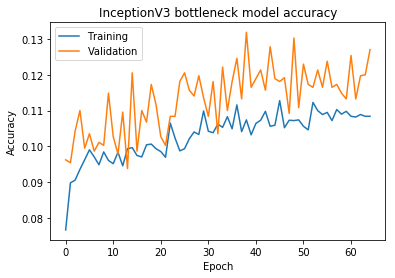

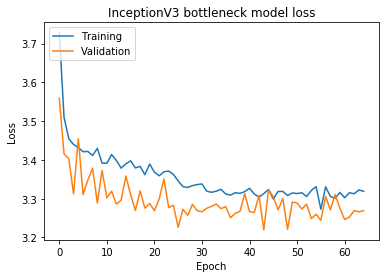

In [23]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/InceptionV3BottleneckBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = InceptionV3Model.fit_generator(generator_train,
                                         steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                         validation_data=generator_validation, 
                                         validation_steps=X_validation.shape[0] // batchSize,
                                         callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 bottleneck model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3BottleneckAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 bottleneck model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3BottleneckLoss.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [24]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/InceptionV3BottleneckBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

Test accuracy of the model (after training): 11.1727%


### Visualize the result of the model 

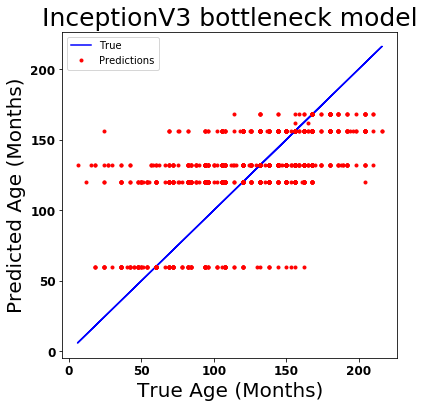

In [25]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('InceptionV3 bottleneck model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/InceptionV3BottleneckResult.pdf', bbox_inches='tight')

### Visualize layer names and layer indices to see how many layers to freeze (to fine-tune the model)

In [26]:
for i, layer in enumerate(baseModel.layers):
   print(i, layer.name)

0 input_1
1 conv2d_5
2 batch_normalization_6
3 activation_1
4 conv2d_6
5 batch_normalization_7
6 activation_2
7 conv2d_7
8 batch_normalization_8
9 activation_3
10 max_pooling2d_5
11 conv2d_8
12 batch_normalization_9
13 activation_4
14 conv2d_9
15 batch_normalization_10
16 activation_5
17 max_pooling2d_6
18 conv2d_13
19 batch_normalization_14
20 activation_9
21 conv2d_11
22 conv2d_14
23 batch_normalization_12
24 batch_normalization_15
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_10
29 conv2d_12
30 conv2d_15
31 conv2d_16
32 batch_normalization_11
33 batch_normalization_13
34 batch_normalization_16
35 batch_normalization_17
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_20
42 batch_normalization_21
43 activation_16
44 conv2d_18
45 conv2d_21
46 batch_normalization_19
47 batch_normalization_22
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_17
52 conv2d_19
53 conv2d_22
54 conv2d_23
55 batch_normalization_18
56 ba

### Train the top few inception blocks

In [27]:
# Let's train the top 3 inception blocks
# Freeze the first 229 layers
for layer in InceptionV3Model.layers[:229]:
   layer.trainable = False
for layer in InceptionV3Model.layers[229:]:
   layer.trainable = True

### Compile the code

In [28]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005, momentum=0.9), metrics=['accuracy'])

### Calculate the classification accuracy of the model (before training)

In [29]:
# Evaluate the test accuracy
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (before training): %.4f%%' % accuracy)

Test accuracy of the model (before training): 11.1727%


### Train the model

Epoch 00000: val_loss improved from inf to 3.16074, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00001: val_loss improved from 3.16074 to 2.95403, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00002: val_loss improved from 2.95403 to 2.94365, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00003: val_loss improved from 2.94365 to 2.89208, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00004: val_loss improved from 2.89208 to 2.87377, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 2.87377 to 2.79838, saving model to SavedModels/InceptionV3FineTunedBest.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve

Epoch 00010: reducing learning rate to 0.0014999999664723873.
Epoch 00011: val_loss improved from 2.79838 to 2.68877, saving mode

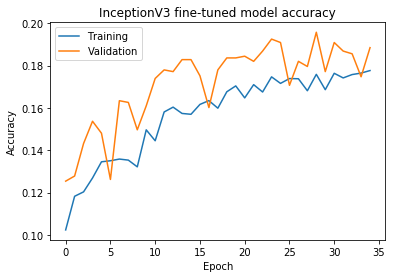

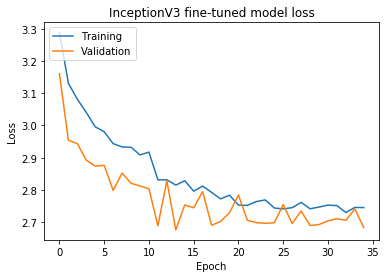

In [30]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/InceptionV3FineTunedBest.hdf5', save_best_only=True, verbose=1)

# Fit the model on batches with real-time data augmentation:
history = InceptionV3Model.fit_generator(generator_train,
                                         steps_per_epoch=X_train.shape[0] // batchSize, epochs=epochs, 
                                         validation_data=generator_validation, 
                                         validation_steps=X_validation.shape[0] // batchSize,
                                         callbacks=[checkPoint, earlyStop, reduceLR], verbose=0)

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 fine-tuned model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3FineTunedAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 fine-tuned model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/InceptionV3FineTunedLoss.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [31]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/InceptionV3FineTunedBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

Test accuracy of the model (after training): 17.9873%


### Visualize the result of the model 

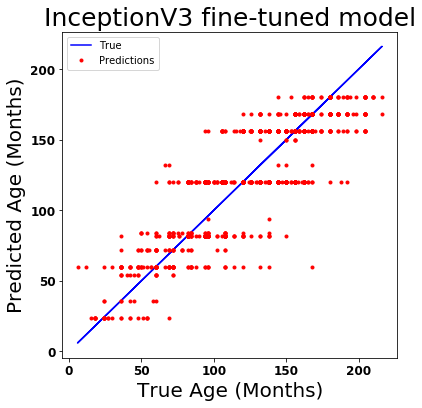

In [32]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_t, y_t, 'b-', label = 'True')
ax1.plot(y_t, y_p, 'r.', label = 'Predictions')
ax1.legend()
ax1.set_title('InceptionV3 fine-tuned model', fontsize=25)
ax1.set_xlabel('True Age (Months)', fontsize=20)
ax1.set_ylabel('Predicted Age (Months)', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/InceptionV3FineTunedResult.pdf', bbox_inches='tight')